# Continuous Control of a Robotic Arm
**Michael Santoro - michael.santoro@du.edu**
## Introduction
This project explores two different Reinforcement Algorithims. This particular enviroment requires continious control. The two algorithims that will be explored are [Deep Deterministic Policy Gradient](https://arxiv.org/abs/1509.02971) (DDPG) [Proximal Policy Opimization](https://arxiv.org/abs/1707.06347) (PPO). DDPG and PPO are two popular algorithms used for solving continuous control problems in reinforcement learning.

This a solution submission for the Deep Reinforcement Learning by Udacity. The problem details can be found [here](https://github.com/udacity/deep-reinforcement-learning/tree/master/p2_continuous-control).

## Enviroment
In this environment, a double-jointed arm can move to target locations. A reward of +0.1 is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. Each action is a vector with four numbers, corresponding to torque applicable to two joints. Every entry in the action vector should be a number between -1 and 1.

There were two unity enviroments provided. The first version contains a single agent. The second version contains 20 identical agents, each with its own copy of the environment.

The environment is considered solved, when the average (over 100 episodes) of those average scores is at least +30.


# Deep Deterministic Policy Gradient
## Overview
[source](https://spinningup.openai.com/en/latest/algorithms/ddpg.html)</br>
Deep Deterministic Policy Gradient (DDPG) is an algorithm which concurrently learns a Q-function and a policy. It uses off-policy data and the Bellman equation to learn the Q-function, and uses the Q-function to learn the policy.

This approach is closely connected to Q-learning, and is motivated the same way: if you know the optimal action-value function $Q^*(s,a)$, then in any given state, the optimal action $a^*(s)$ can be found by solving

$$
a^*(s) = \arg \max_a Q^*(s,a).
$$

DDPG interleaves learning an approximator to $Q^*(s,a)$ with learning an approximator to $a^*(s)$, and it does so in a way which is specifically adapted for environments with continuous action spaces. But what does it mean that DDPG is adapted specifically for environments with continuous action spaces? It relates to how we compute the max over actions in $\max_a Q^*(s,a)$.

When there are a finite number of discrete actions, the max poses no problem, because we can just compute the Q-values for each action separately and directly compare them. (This also immediately gives us the action which maximizes the Q-value.) But when the action space is continuous, we can’t exhaustively evaluate the space, and solving the optimization problem is highly non-trivial. Using a normal optimization algorithm would make calculating $\max_a Q^*(s,a)$ a painfully expensive subroutine. And since it would need to be run every time the agent wants to take an action in the environment, this is unacceptable.

Because the action space is continuous, the function Q^*(s,a) is presumed to be differentiable with respect to the action argument. This allows us to set up an efficient, gradient-based learning rule for a policy $\mu(s)$ which exploits that fact. Then, instead of running an expensive optimization subroutine each time we wish to compute $\max_a Q(s,a)$, we can approximate it with $\max_a Q(s,a) \approx Q(s,\mu(s))$. See the Key Equations section details.

DDPG is an off-policy algorithm. DDPG can only be used for environments with continuous action spaces. DDPG can be thought of as being deep Q-learning for continuous action spaces.

## Implementation
The agent code is located in `ddpg_agent.py` the agent has been modified from the [pendulum](https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-pendulum) example.

There are two deep nueral networks used for different purposes. The first being the Actor network which takes as an input the state and the output is the action input for the enviroment. The second network is the Critic network used to take as an input the state and action and produce the reward. 

The algorithim includes the use of a target and a local version of each of these deep neural networks. This is to stabilize updates to reduce cycling back and forth. These updates are controlled through the use of the $\tau$ parameter. For this problem $\tau=0.001$ as suggested in the paper.

The agent also includes a noising process which is the Ornstein-Uhlenbeck process. The use of noise assists in exploration, as actions will be modified in an attempt to discover more advantageous behavior. 

The last component of the agent in the ddpg algorithim is a replay buffer. The replay buffer saves tuples of state, action, reward, next done, and completion status. These experiences can then be sampled when a random batch is pulled for learning.

The pseudo code for the process is shown below.
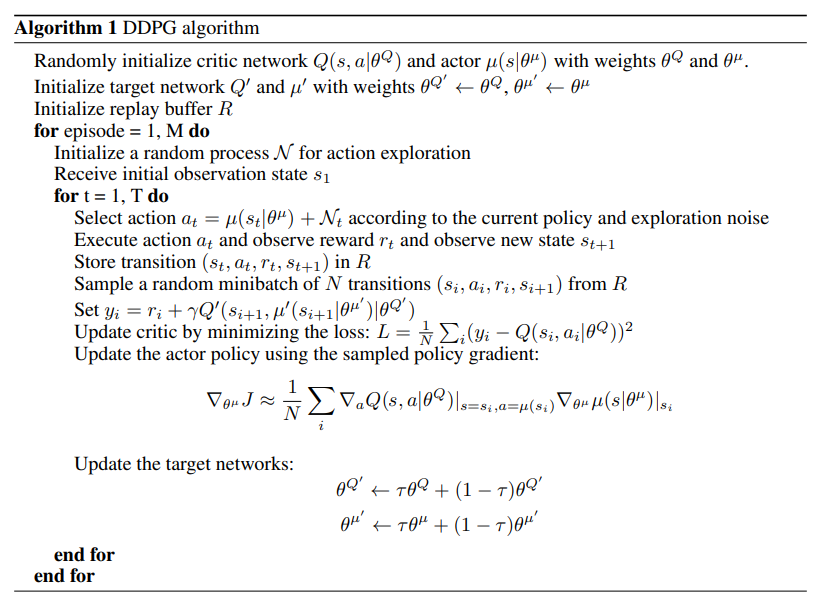





Parameters were set to the following for training:
- Buffer Size: $5*10^{5}$
- Mini Batch Size: $64$
- Discount Factor: $\gamma = 0.99$
- Learning Rate Actor: $10^{-4}$
- Learning Rate Critic: $10^{-3}$
- Layer 2 Decay: $0.0$
- Critic Loss Function: "l1_smooth"

Noise Specific Parameters:
- $\theta$: $0.15$
- $\sigma$: $0.2$

Overall Training Parameters:
- Number of Episodes: $1000$
- Episode Max Time: $1000$

## Challenges
- **Poor Initial Training** - Initial training would result some improvement on scoring but then leveling at or around an initial score of 1.
- **Modification to the Algorithim** - In the udacity knowledge Q&A there were others expeiencing these results, mentors had suggested that updating every time step may be to frequent and it may be advantageous to change the algorthim on the line that says sample a mini-batch. I modified this to be done every $20$ time steps. It was also recomended to the learn step multiple times, I made this change as well to complete $60$ epochs per time learn.
- **Model Architecures** - For the enviroment sample similar two layer networks are used for the actor and critic networks. This was not successful for me, and it was suggested to add a fully connected layer to the Critic Layer and change the parameter config and I completed that.
- **Loss Function** - Due the small loss conditions initially, I opted to use the l1_smooth loss which should result in a mixed advantages of using mean squared error and mean absolute error.
- **Bath-Size** - Initially it was advantageous to keep the batch-size small enough to not have the experiences where the scores were $0$ and large enough that when a batch was sampled there would be atleast one positive reward.
- **Buffer-Size** - I opted to keep the Replay Buffer relatively small to try to bias the model to only learn from newer experiences.



## Results

### Plot of Rewards

In [ ]:
import pandas as pd

### Loss Plots

### Demonstration of Model

In [8]:
import json
import torch
from ddpg_agent import Agent
from unityagents import UnityEnvironment

from easydict import EasyDict

with open('ddpg_config.json', 'r') as f:
    d = json.load(f)
    ddpg_config = EasyDict(d)

env = UnityEnvironment(file_name="reacher_v1\Reacher.exe")
agent = Agent(state_size=33, action_size=4, random_seed=42)

# load the weights from file
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

for i in range(3):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    for j in range(200):
        action = agent.act(state) #Select an Action
        action = action.astype(np.int32)
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        agent.step(state, action, reward, next_state, done)
        state = next_state
        if done:
            break 
            
env.close()

OSError: handle is closed

ERROR:root:Exception calling application: [WinError 232] The pipe is being closed
Traceback (most recent call last):
  File "c:\Users\micha\miniconda3\envs\drlnd\lib\site-packages\grpc\_server.py", line 385, in _call_behavior
    return behavior(argument, context), True
  File "c:\Users\micha\miniconda3\envs\drlnd\lib\site-packages\unityagents\rpc_communicator.py", line 25, in Exchange
    self.child_conn.send(request)
  File "c:\Users\micha\miniconda3\envs\drlnd\lib\multiprocessing\connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "c:\Users\micha\miniconda3\envs\drlnd\lib\multiprocessing\connection.py", line 280, in _send_bytes
    ov, err = _winapi.WriteFile(self._handle, buf, overlapped=True)
BrokenPipeError: [WinError 232] The pipe is being closed


# Proximal Policy Optimization
## Overview
[source](https://spinningup.openai.com/en/latest/algorithms/ppo.html)

PPO is motivated by the same question as TRPO: how can we take the biggest possible improvement step on a policy using the data we currently have, without stepping so far that we accidentally cause performance collapse? Where TRPO tries to solve this problem with a complex second-order method, PPO is a family of first-order methods that use a few other tricks to keep new policies close to old. PPO methods are significantly simpler to implement, and empirically seem to perform at least as well as TRPO.

There are two primary variants of PPO: PPO-Penalty and PPO-Clip.

PPO-Penalty approximately solves a KL-constrained update like TRPO, but penalizes the KL-divergence in the objective function instead of making it a hard constraint, and automatically adjusts the penalty coefficient over the course of training so that it’s scaled appropriately.

PPO-Clip doesn’t have a KL-divergence term in the objective and doesn’t have a constraint at all. Instead relies on specialized clipping in the objective function to remove incentives for the new policy to get far from the old policy.

Here, we’ll focus only on PPO-Clip (the primary variant used at OpenAI).

PPO is an on-policy algorithm. PPO can be used for environments with either discrete or continuous action spaces.

## Implementation

I leveraged the code presented described [here](https://github.com/vwxyzjn/cleanrl/blob/master/cleanrl/ppo.py). I also leveraged this [amazing paper](https://fse.studenttheses.ub.rug.nl/25709/1/mAI_2021_BickD.pdf) and [these details](https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/)




In [ ]:


agent = Agent(state_size=33, action_size=4, random_seed=seed)

# load the weights from file
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

for i in range(3):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    for j in range(200):
        action = agent.act(state) #Select an Action
        action = action.astype(np.int32)
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        agent.step(state, action, reward, next_state, done)
        state = next_state
        if done:
            break 
            
env.close()

c:\Users\micha\miniconda3\envs\drlnd\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


# Ideas for Future Work